# Analysis of Arlington County Bus Routes
## Data sources
<a href="https://api.census.gov/data/2010/sf1/?get=P0120001&for=block:*&in=state:51%20county:013">2010 US Census</a>
<a href="https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/">TIGER/Line shapefiles</a>
## Organize data
We need to take the raw population data, which is provided on a US Census Block level, and map that to latitude and longitude. We can do this via TIGER/Line shapefiles. I have preloaded the data into 2 files, so no API request is required. We will save the original Census data, along with the bounding box for each block and the centroid (calculated from the bounding box).

In [5]:
import re
import shapefile
import numpy as np
import pandas as pd

def calc_centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

data = []
with open('census_api_resp.json', 'r') as fid:
    lines = fid.readlines()
    for line in lines[1:]:
        line = re.sub(r'\[|\]|"','',line).rstrip(',\n')
        pop, state, county, tract, block = line.split(',')
        data.append({'pop': pop,
                    'state': state,
                    'county': county,
                    'tract': tract,
                    'block': block})
sf = shapefile.Reader('tl_2010_51013_tabblock10/tl_2010_51013_tabblock10.shp')
shapes = sf.shapes()
indx = 0
for shape in shapes:
    arr = np.array(shape.points)
    lat, lon = calc_centroid(arr)
    lon_1, lat_1, lon_2, lat_2 = shape.bbox
    data[indx]['cent_lat'] = lat
    data[indx]['cent_lon'] = lon
    data[indx]['bbox_lat1'] = lat_1
    data[indx]['bbox_lat2'] = lat_2
    data[indx]['bbox_lon1'] = lon_1
    data[indx]['bbox_lon2'] = lon_2
    indx += 1
df = pd.DataFrame(data)
df.head(5)

,bbox_lat1,bbox_lat2,bbox_lon1,bbox_lon2,block,cent_lat,cent_lon,county,pop,state,tract
0,38.842309,38.844156,-77.107485,-77.105971,1000,-77.106865,38.843071,013,184,51,100100
1,38.842555,38.843780,-77.106459,-77.104793,1001,-77.105757,38.843085,013,21,51,100100
2,38.897242,38.898117,-77.099421,-77.098295,1002,-77.098929,38.897666,013,40,51,100100
3,38.883396,38.886095,-77.104035,-77.099635,1003,-77.101934,38.884860,013,77,51,100100
4,38.844745,38.847054,-77.095230,-77.089518,1004,-77.092394,38.845805,013,33,51,100100


## Calculate clusters
We are going to start testing clusters with the k-means algorithm. However, we want to include the population of each block as a weight for that point. In order to do this, we will generate a new, larger array of points, with 1 point for each person. For example, (38.84, -77.11, 184) would become 184 copies of (38.84, -77.11). However, we aren't going to do that exactly. Instead, we will take the bounding box for each block from before and randomly distribute points within that area.

In [6]:
import random

big_data = []
for indx, row in df.iterrows():
    for _ in range(int(row['pop'])):
        lat_1, lat_2, lon_1, lon_2  = row['bbox_lat1':'bbox_lon2']
        lat = random.uniform(lat_1, lat_2)
        lon = random.uniform(lon_1, lon_2)
        big_data.append([lat, lon])
big_arr = np.array(big_data)
big_arr

array([[ 38.84398591, -77.10611021],
       [ 38.84249985, -77.10675945],
       [ 38.84367419, -77.10684007],
       ...,
       [ 38.87711907, -77.07635143],
       [ 38.87964591, -77.07403284],
       [ 38.87980199, -77.07684514]])

## K-means clustering
Now that we have an array of points, we can perform k-means clustering to find the best locations for our bus stops. `num_stops` is the number of bus stops we are charting.

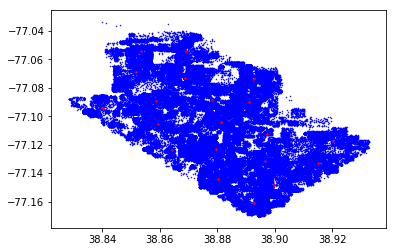

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

num_stops = 20
km = KMeans(n_clusters=num_stops, random_state=0).fit(big_arr)
cl_cent = km.cluster_centers_
plt.figure()
plt.scatter(big_arr[:,0], big_arr[:,1], s=0.25, c='blue')
plt.scatter(cl_cent[:,0], cl_cent[:,1], s=2, c='red')
plt.show()